# Fast resampling of univariate trigonometric polynomials

In this notebook we will implement the method described in https://arxiv.org/pdf/1507.06174.pdf to resample univariate trigonometric polynomials. Let's say we have a trigonometric polynomial:
$$
f : x \mapsto \sum_{k=-n/2}^{n/2-1} \alpha_k \exp\left(i k x\right)
$$

and we know, for a set of points $(y_1, \dots, y_N) \in [-\pi, \pi]^N$, its values $f(y_1), \dots, f(y_N)$ with $N \geq n$. We want to estimate, for a new set of points $(x_1, \dots, x_M) \in [-\pi, \pi]^M$, the values taken by $f$. This can be done by first finding $\alpha$, by solving:
$$
\min_{\alpha \in \mathbb{C}^n} \sum_{j=1}^N \left|f(y_j) - \sum_{k=-n/2}^{n/2-1} \alpha_k \exp\left(i k y_j\right)\right|^2
$$

We use the following notations: $f = (f_1, \dots, f_N)$ and $A_{j, k} = \exp\left( i k y_j\right)$. We then have to solve:
$$
\min_{\alpha \in \mathbb{C}^n} \|f - A \alpha\|^2
$$

The solution satisfies:
$$
A^\dagger A \alpha = A^\dagger f
$$

which means we find alpha by inverting $A^\dagger A$ which takes $\mathcal{O}(n^2)$ but can be precomputed since we now in advance 

In [79]:
import numpy as np
from scipy.linalg import toeplitz, matmul_toeplitz, solve_toeplitz


In [80]:
def compute_A(y, n):
    half_n = n//2
    k = np.arange(-half_n, half_n)
    return np.exp(1j * np.einsum("j,k->jk", y, k))


In [81]:
def compute_AdaggerA(y, n):
    aux = -1j * np.arange(n)
    aux = np.exp(aux[:, None] * y[None, :])
    c = np.einsum("ij->i", aux)
    return toeplitz(c)


Check that we compute $A^\dagger A$:

In [82]:
n = 4
y = np.random.rand(6)
A = compute_A(y, n)
naive_AdagA = A.conj().T @ A
AdagA = compute_AdaggerA(y, n)
np.max(np.abs(naive_AdagA - AdagA))


9.155133597044475e-16

Check the scipy function ``matmul_toeplitz``:

In [83]:
x = np.random.rand(n)
np.max(np.abs(matmul_toeplitz(naive_AdagA[:, 0], x) - naive_AdagA @ x))


8.881784197001252e-16

# Check that $A$ applies the type-1 NUFFT

In [84]:
def trigo_poly(alpha, x):
    n = len(alpha)
    half_n = n//2
    k = np.arange(-half_n, half_n)
    kx = np.einsum("k,x->kx", k, x)
    return np.einsum("kx,k->x", np.exp(1j * kx), alpha)


In [85]:
alpha = np.random.rand(n)
print(np.max(np.abs(A @ alpha - trigo_poly(alpha, y))))


2.220446049250313e-16


# Inverse of Toeplitz matrix

In [86]:
def compute_inverse(c, r=None):
    """
    Computes the Gohberg-Semencul decomposition of T^-1.

    T^-1 = (M1 @ M2 - M3 @ M4) / x0
    """

    e0 = np.zeros_like(c)
    e0[0] = 1

    e1 = np.zeros_like(c)
    e1[-1] = 1

    if r is None:
        x = solve_toeplitz(c, e0)
        y = solve_toeplitz(c, e1)

    else:
        r = np.conjugate(c)
        x = solve_toeplitz((c, r), e0)
        y = solve_toeplitz((c, r), e1)

    x_a = np.zeros_like(x)
    x_a[0] = x[0]

    x_b = np.zeros_like(x)
    x_b[1::] = x[:0:-1]

    M_1 = toeplitz(x, x_a)
    M_4 = toeplitz(np.zeros_like(x), x_b)

    y_a = np.zeros_like(y)
    y_a[0] = y[-1]

    y_b = np.zeros_like(y)
    y_b[1::] = y[:-1]

    M_2 = toeplitz(y_a, y[::-1])
    M_3 = toeplitz(y_b, np.zeros_like(y))

    return (M_1 @ M_2 - M_3 @ M_4) / x[0]


In [87]:
n = 100
y = np.random.rand(1000) * 2 * np.pi - np.pi


In [88]:
T = compute_AdaggerA(y, n)
c = T[:, 0]
np.max(np.abs(np.linalg.inv(T) - compute_inverse(c)))


6.505656400415774e-19

# Interpolate

In [89]:
def compute_alpha(y, n, f):
    A = compute_A(y, n)
    T = compute_AdaggerA(y, n)
    inv_T = compute_inverse(T[:, 0])
    alpha = inv_T @ A.conj().T @ f
    return alpha


In [90]:
def interpolate(y, n, f, x):
    alpha = compute_alpha(y, n, f)
    return trigo_poly(alpha, x)


In [91]:
n = 10
alpha = np.random.rand(n)
y = 2 * np.pi * np.random.random(10) - np.pi
f = trigo_poly(alpha, y)
sol = compute_alpha(y, n, f)


In [92]:
np.max(np.abs(alpha - sol))


6.846191059409557e-12

# Numerical stability

In [110]:
import matplotlib.pyplot as plt


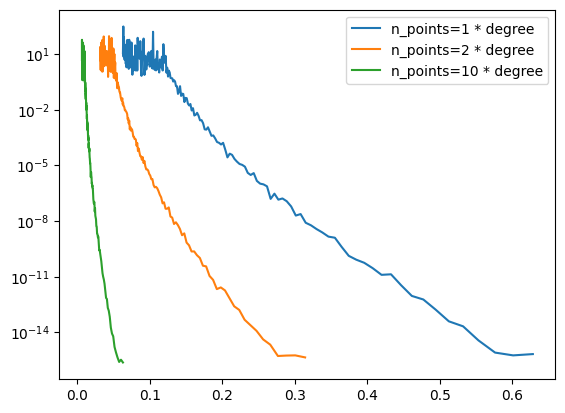

In [140]:
n = 10
alpha = np.random.rand(n)
errs = []
deltas = np.linspace(1, 10, 200)

for k in [1, 2, 10]:
    errs = []
    for delta in deltas:
        pos = 2 * np.pi * np.arange(k * n) - np.pi
        pos = pos / (k * n * delta)
        # pos = np.linspace(-np.pi / delta, np.pi / delta, k * n, endpoint=False)
        samples = trigo_poly(alpha, pos)
        sol = compute_alpha(pos, n, samples)
        errs.append(np.max(np.abs(sol - alpha)))
    plt.plot(2 * np.pi / (k * n * deltas), errs,
             label=f'n_points={k} * degree')

plt.yscale("log")
plt.legend()


In [ ]:
n = 10
alpha = np.random.rand(n)
errs = []
deltas = np.linspace(1, 10, 200)

for k in [1, 10, 100]:
    errs = []
    for delta in deltas:
        pos = np.linspace(-np.pi / delta, np.pi / delta, k * n, endpoint=False)
        samples = trigo_poly(alpha, pos)
        sol = compute_alpha(pos, n, samples)
        errs.append(np.max(np.abs(sol - alpha)))
    plt.plot(deltas, errs, label=f'n_points={k} * degree')

plt.yscale("log")
plt.legend()


# Test with the PPFFT

The horizontal and vertical samples of the pseudo polar Fourier transform of an image $I$ are:
$$
\widehat{I}_h (k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{-\frac{2lk}{n}u + kv}{m} \right) \\
\widehat{I}_v (k, l) = \sum_{u \in \mathcal{D}(n)} \sum_{v \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku -\frac{2lk}{n}v}{m} \right)
$$

for $(k, l) \in \llbracket -n, n \rrbracket \times \llbracket -n/2, n/2 \rrbracket$. Let $k \in \llbracket -n, n \rrbracket$. We have:
$$
\begin{align*}
\forall l \in \llbracket -n/2, n/2 \rrbracket, \, \widehat{I}_v(k, l) &= \sum_{v \in \mathcal{D}(n)} \left[ \sum_{u \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku}{m} \right) \right] \exp\left(2i\pi \frac{2lk}{nm}v \right) \\
&= P\left(\frac{4\pi lk}{nm}\right)
\end{align*}
$$

where:
$$
P(x) = \sum_{v \in \mathcal{D}(n)} \left[ \sum_{u \in \mathcal{D}(n)} I(u, v) \exp\left(-2i\pi \frac{ku}{m} \right) \right] \exp\left(ivx \right) = \sum_{v \in \mathcal{D}(n)} \alpha_v \exp\left(ivx \right)
$$

therefore, we should be able to compute the coefficients of $\alpha_v$

In [141]:
from ppfft import ppfft


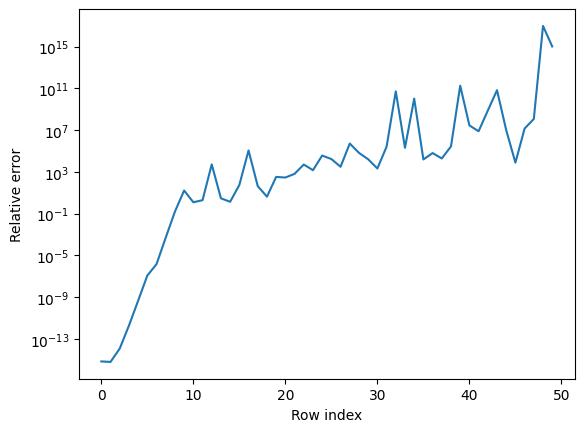

In [193]:
n = 50
m = 2 * n + 1
im = np.random.rand(n, n)
hori, vert = ppfft(im)

errs = []

for k in range(-n, 0):
    true_alpha = np.einsum(
        "uv,u->v", im, np.exp(-2j * np.pi * k * np.arange(-(n//2), n//2) / m))
    samples = vert[:, k + n]
    positions = 4 * np.pi * k * np.arange(-(n//2), n//2 + 1) / (n * m)
    alpha = compute_alpha(positions, n, samples)
    errs.append(np.sum(np.abs(true_alpha - alpha)**2) /
                np.sum(np.abs(true_alpha)**2))

plt.plot(errs)
plt.xlabel("Row index")
plt.ylabel("Relative error")
plt.yscale("log")


4.843035321448964e-07


# Summary of steps

Parameters:
- $y \in [-\pi, \pi]^N$
- $f \in \mathbb{C}^N$ : values of a trigonometric polynomial of degree $n$ sampled at $y$ 

Precomputations:
- $M_1, M_2, M_3, M_4$ : Toeplitz matrices giving the inverse of $A^\dagger A$ where $A_{j, k} = \exp(i k y_j)$ is the matrix of some non uniform Fourier transform

Algorithm:
- Compute $\beta = A^\dagger f$ : adjoint NUFFT in $\mathcal{O}(n \log(1/\epsilon))$ where $\epsilon$ is a precision parameter
- Compute $\alpha = x_0^{-1} (M_1 M_2 - M_3 M_4) \beta$ : 4 applications of Toeplitz matrices, in $\mathcal{O}(n \log(n))$
- Sample the trigonometric polynomial corresponding to $\alpha$ : either NUFFT or FFT depending on the target positions